## Comparing the deviation of FD simulation results from shooting method with changing discretisation

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np
import scipy

In [2]:
n_x = [100, 500, 1000]

In [3]:
# Material parameters
A = 13e-12  # Jm^-1
D = 3e-3    # Jm^-2
M_s = 8.6e5 # Am^-1
K_u = 4e5   # Jm^-3

# Use units in the nm scale
nm = 1e-9
delta = (np.sqrt(A / K_u)) / nm
xi = (2 * A / D) / nm

In [4]:
# Set of differential equations for (u, v)
def ode_1d(theta, r, delta):
    return np.array([theta[1], 
                      np.cos(theta[0]) * np.sin(theta[0]) / delta ** 2
                      ])

In [5]:
results_mx_oommf = dict()
results_mx_mumax = dict()
results_mz_oommf = dict()
results_mz_mumax = dict()
for i in n_x:
    mesh = df.Mesh(p1=(-50e-9, 0, 0), p2=( 50e-9, 1e-9, 1e-9), n=(i, 1, 1))
    system = mm.System(name="chain")
    system.m = df.Field(mesh, nvdim=3, value=[0, 0, 1], norm=M_s)
    system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass="Cnv_z") + mm.UniaxialAnisotropy(K=K_u, u=[0, 0, 1])
    mindriver = oc.MinDriver()
    mindriver.drive(system)
    mx = np.squeeze(system.m.orientation.array[..., 0])
    mz = np.squeeze(system.m.orientation.array[..., 2])
    
    r_array = np.array([system.m.mesh.region.pmin[0]] + list(system.m.mesh.points.x) + [system.m.mesh.region.pmax[0]]) / nm
    def solve_ode(a, sign=1):  
        # Impose the condition over the angle rather than its derivative
        solution, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), 
                                                [np.arcsin(sign * delta / xi), a], r_array, full_output=True)
        # By inspection we found that the right extrema must be positive to match
        # the condition for the derivative
        return solution[:, 0][-1] - np.arcsin(-sign * delta / xi)
    
    guess_interface = scipy.optimize.brentq(lambda a: solve_ode(a, sign=-1), 0.2, 0.)
    solution_interface, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), [np.arcsin(- delta / xi), guess_interface], r_array, full_output=True)
    
    mumax_m = df.Field.from_file(f"mumax3-files/m_interface_{i}_mumax3_periodic_y.ovf")
    mumax_mx = np.squeeze(mumax_m.orientation.array[..., 0])
    mumax_mz = np.squeeze(mumax_m.orientation.array[..., 2])
    
    results_mx_oommf[f"{i}"] = [system.m.mesh.points.x, np.sin(solution_interface[1:-1, 0]) - mx]
    results_mz_oommf[f"{i}"] = [system.m.mesh.points.x, np.cos(solution_interface[1:-1, 0]) - mz]
    results_mx_mumax[f"{i}"] = [system.m.mesh.points.x, np.sin(solution_interface[1:-1, 0]) - mumax_mx]
    results_mz_mumax[f"{i}"] = [system.m.mesh.points.x, np.cos(solution_interface[1:-1, 0]) - mumax_mz]

Running OOMMF (ExeOOMMFRunner)[2023/11/24 17:34]... (0.3 s)
Running OOMMF (ExeOOMMFRunner)[2023/11/24 17:34]... (0.3 s)
Running OOMMF (ExeOOMMFRunner)[2023/11/24 17:34]... (0.8 s)


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_10955/168759927.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta m_x$")


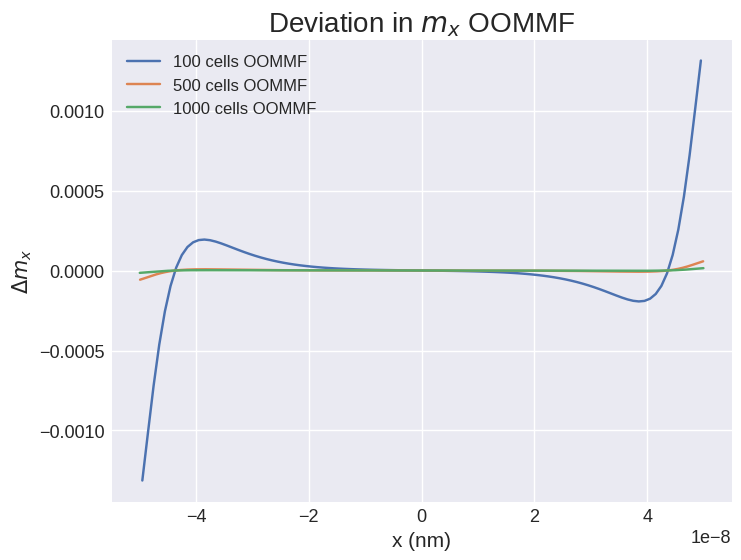

In [6]:
import matplotlib.pyplot as plt


plt.plot(results_mx_oommf["100"][0], results_mx_oommf["100"][1], label="100 cells OOMMF")
plt.plot(results_mx_oommf["500"][0], results_mx_oommf["500"][1], label="500 cells OOMMF")
plt.plot(results_mx_oommf["1000"][0], results_mx_oommf["1000"][1], label="1000 cells OOMMF")
plt.legend()
plt.grid()
plt.xlabel("x (nm)")
plt.ylabel("$\Delta m_x$")
plt.title("Deviation in $m_x$ OOMMF")
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_10955/4196378931.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta m_x$")


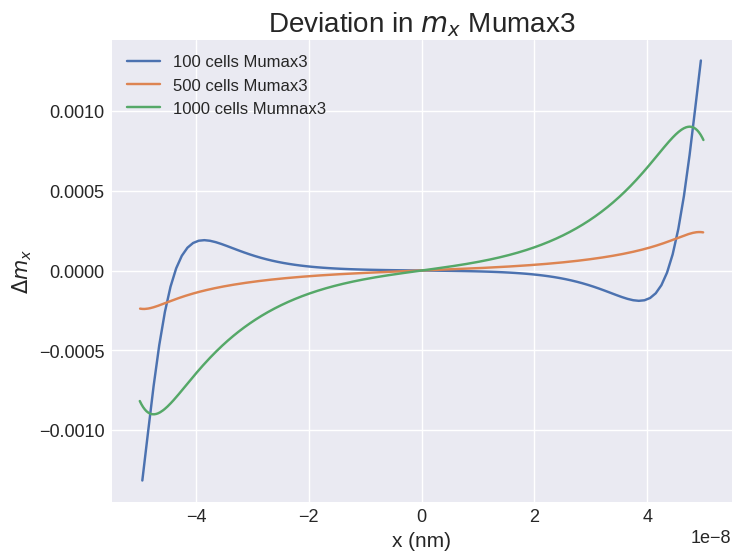

In [7]:
plt.plot(results_mx_mumax["100"][0], results_mx_mumax["100"][1], label="100 cells Mumax3")
plt.plot(results_mx_mumax["500"][0], results_mx_mumax["500"][1], label="500 cells Mumax3")
plt.plot(results_mx_mumax["1000"][0], results_mx_mumax["1000"][1], label="1000 cells Mumnax3")

plt.legend()
plt.grid()
plt.xlabel("x (nm)")
plt.ylabel("$\Delta m_x$")
plt.title("Deviation in $m_x$ Mumax3")
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\D'
<>:7: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_10955/3553667354.py:7: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta m_z$")


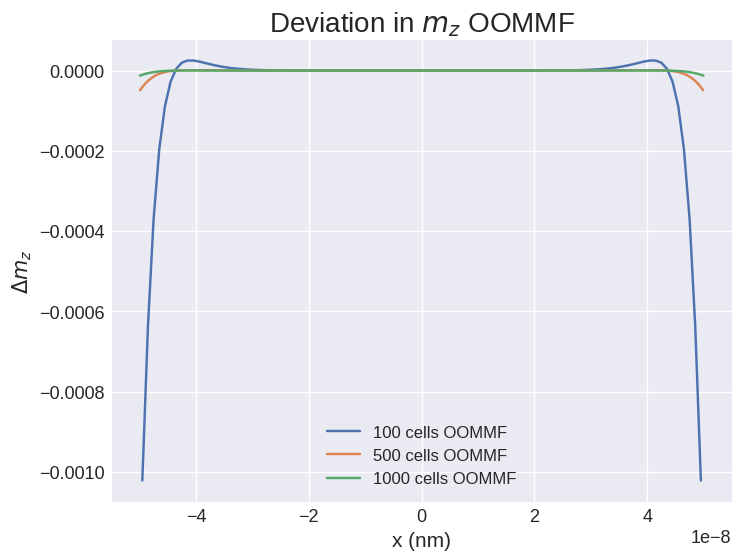

In [8]:
plt.plot(results_mz_oommf["100"][0], results_mz_oommf["100"][1], label="100 cells OOMMF")
plt.plot(results_mz_oommf["500"][0], results_mz_oommf["500"][1], label="500 cells OOMMF")
plt.plot(results_mz_oommf["1000"][0], results_mz_oommf["1000"][1], label="1000 cells OOMMF")
plt.legend()
plt.grid()
plt.xlabel("x (nm)")
plt.ylabel("$\Delta m_z$")
plt.title("Deviation in $m_z$ OOMMF")
plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_10955/2432504823.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta m_z$")


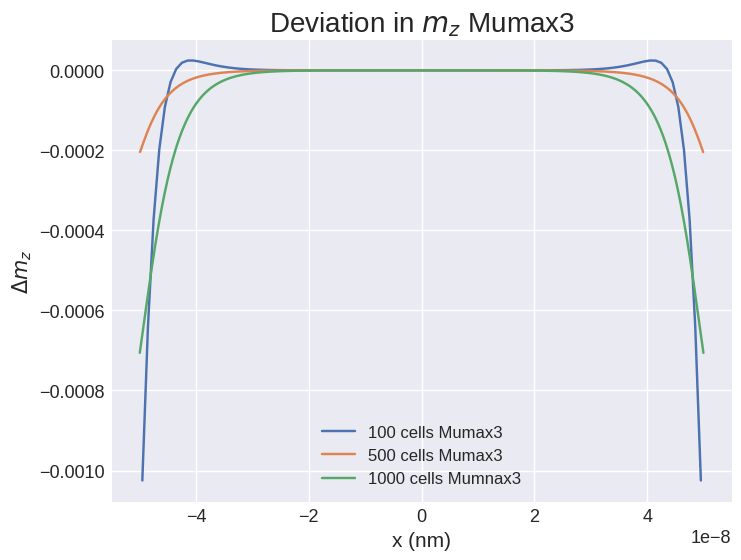

In [9]:
plt.plot(results_mz_mumax["100"][0], results_mz_mumax["100"][1], label="100 cells Mumax3")
plt.plot(results_mz_mumax["500"][0], results_mz_mumax["500"][1], label="500 cells Mumax3")
plt.plot(results_mz_mumax["1000"][0], results_mz_mumax["1000"][1], label="1000 cells Mumnax3")

plt.legend()
plt.grid()
plt.xlabel("x (nm)")
plt.ylabel("$\Delta m_z$")
plt.title("Deviation in $m_z$ Mumax3")
plt.show()